In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data.sampler as sampler

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("C:/Users/NikhilD/MachineLearning/datasets/FacialExpressionDataset/fer2013.csv")
labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [3]:
file_num = 1
start_dir = "C:/Users/NikhilD/MachineLearning/datasets/FacialExpressionDataset/Images/"
dataset_distribution = [0 for i in range(len(labels))]
for i in range(len(df)):
    pixels = [float(j) for j in df["pixels"][i].split()]
    t = torch.tensor(pixels).reshape((48, 48))/255
    pil_image = transforms.ToPILImage()(t)
    path = start_dir + df["Usage"][i] + "/" + labels[df["emotion"][i]] + "/"
    pil_image.save(path+str(file_num)+".jpg", "JPEG")
    dataset_distribution[df["emotion"][i]] += 1
    file_num += 1

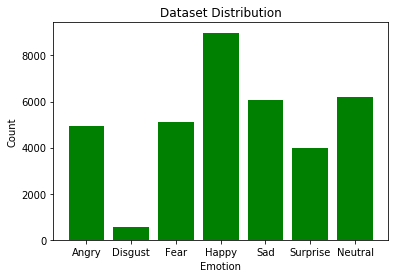

In [4]:
plt.title("Dataset Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.bar([i for i in range(len(labels))], dataset_distribution, color='green')
plt.xticks([i for i in range(len(labels))], labels)
plt.show()

In [68]:
compose_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                                    torchvision.transforms.ToTensor()])

train_set = torchvision.datasets.ImageFolder(root=start_dir+"Training", transform=compose_transform)
validation_set = torchvision.datasets.ImageFolder(root=start_dir+"PrivateTest", transform=compose_transform)
test_set = torchvision.datasets.ImageFolder(root=start_dir+"PublicTest", transform=compose_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

In [69]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(9)
        self.conv2 = nn.Conv2d(in_channels=9, out_channels=18, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(18)

        self.fc1 = nn.Linear(in_features=18*9*9, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=7)
        
    def forward(self, t):
        t = self.conv1(t)
        t = self.conv1_bn(t)
        t = functional.relu(t)
        t = functional.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv2(t)
        t = self.conv2_bn(t)
        t = functional.relu(t)
        t = functional.max_pool2d(t, kernel_size=2,  stride=2)

        t = functional.relu(self.fc1(t.reshape(-1, 18*9*9)))
        t = functional.relu(self.fc2(t))
        t = self.out(t)
        
        return t

In [70]:
network = ConvolutionalNetwork()
network.cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

In [71]:
# function to evaluate the CNN
# net = convolutional neural network
# loader = the dataloader object for test/validation set
# return: the accuracy of the network
def evaluate_network(net, loader):
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            images, data_labels = data
            images = images.to(device)
            data_labels = data_labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs.data, 1)
            total += data_labels.size(0)
            correct += (predictions==data_labels).sum().item()
    return correct/total * 100

# function to train the CNN
# net = convolutional neural network
# tloader = dataloader object for train set
# vloader = dataloader object for validation set
# return: (list of accuracies, number of epochs)
def train_network(net, tloader, vloader, optimizer, loss_function):
    torch.set_grad_enabled(True)
    accuracies = []
    num_epochs = 0
    plateau = 0
    while(num_epochs < 30): 
        # training loop
        for data in tloader:
            images, data_labels = data
            images = images.to(device)
            data_labels = data_labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs, data_labels)
            loss.backward()
            optimizer.step()
        
        accuracies.append(evaluate_network(net, vloader))
        num_epochs += 1
        
        i = num_epochs - 1
        if i >= 1 and np.abs(accuracies[i] - accuracies[i-1]) < 1:
            plateau += 1
        else:
            plateau = 0
        if plateau == 7:
            break          
                
    return accuracies, num_epochs

In [72]:
accuracies_list = []
accuracies_list.append(evaluate_network(network, validationloader))
accuracies, epochs = train_network(network, trainloader, validationloader, optimizer, loss_function)

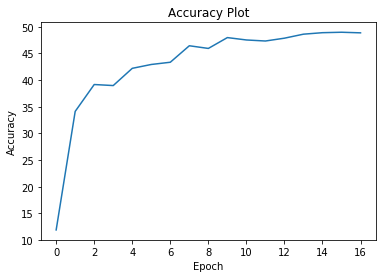

In [73]:
accuracies_list.extend(accuracies)
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_list)

In [74]:
# helper function for SubsetRandomSampler
def extract_indices(dataset):
    indices = [[] for i in range(len(labels))]
    for i, data in enumerate(dataset):
        indices[data[1]].append(i)
    return indices    

# function to determine how well the network classifies
# for each emotion category from the given dataset
def extract_accuracies(network, dataset):
    indices = extract_indices(dataset)
    emotion_accuracies = []
    for i in range(len(labels)):
        loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, sampler=sampler.SubsetRandomSampler(indices[i]))
        emotion_accuracies.append(evaluate_network(network, loader))
    return emotion_accuracies

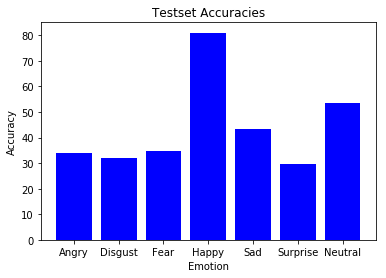

OVERALL ACCURACY:  48.56505990526609


In [75]:
test_accuracies = extract_accuracies(network, test_set)
plt.title("Testset Accuracies")
plt.xlabel("Emotion")
plt.ylabel("Accuracy")
plt.bar([i for i in range(len(labels))], test_accuracies, color='blue')
plt.xticks([i for i in range(len(labels))], labels)
plt.show()
print("OVERALL ACCURACY: ", evaluate_network(network, testloader))

In [79]:
torch.save(network.state_dict(), "C:/Users/NikhilD/MachineLearning/NetworkModels/EmotionCNNV2.pth")